In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import ternary
import copy
import math

In [2]:
import os
import json
class read_inputjson_BCC_screw_single_calculation: 
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
        else:
            print('input file not in current directory')
            quit()
        
        self.model = self.data["model"]
        self.name = self.data["material"]
        # properties
        self.properties = self.data['properties']
        # adjustable scalers
        self.adjustable_scalers = self.data['adjustables']
        # exp conditions
        self.conditions = self.data['conditions']
        # output file
        try: 
            self.savefilename = self.data['savefile']
        except:
            self.savefilename = self.data["material"] + '_out'
        

In [3]:


class ss_model_M_C_screw:
    # BCC screw dislocation model: Maresca-Curtin 2019: https://doi.org/10.1016/j.actamat.2019.10.007
    # single calculation, using averaged properties. 

    def __init__(self,
                 inputdata
                ):

        # adjustable scalers
        self.kink_width = inputdata.adjustable_scalers['kink_width']  
        self.Delta_V_p_scaler = inputdata.adjustable_scalers['Delta_V_p_scaler']  
        self.Delta_E_p_scaler = inputdata.adjustable_scalers['Delta_E_p_scaler'] 
        
        # some constants
        self.boltzmann_J = 1.38064852*10**(-23) #J/K
        self.boltzmann_eV = 8.617333262145e-5 #eV
        self.J2eV = 6.2415093433*10**18 # covert J to eV 
        self.eV2J = 1/self.J2eV
        
        # properties
        self.a = inputdata.properties['a'] * 10**(-10)             #m    # lattice constant
        self.a_p = self.a*np.sqrt(2/3)  # Peierls spacing
        self.b = self.a*np.sqrt(3)/2
        
        self.E_k = inputdata.properties['E_k'] * self.eV2J             # J   # kink formation energy
        self.Delta_E_p = self.Delta_E_p_scaler * inputdata.properties['Delta_E_p'] * self.eV2J  # J   # screw-solute interaction
        self.Delta_V_p = self.Delta_V_p_scaler * inputdata.properties['Delta_V_p'] * self.eV2J /self.b# J/b   # Peierls barrier
        
        self.E_si = inputdata.properties['E_f_si']   * self.eV2J         #J   # formation energy of self-interstitial
        self.E_v = inputdata.properties['E_f_v']     * self.eV2J         #J   # formation energy of vacancy 
        
    
        # exp conditions
        self.T = np.arange(inputdata.conditions['temperature']['min'],
                           inputdata.conditions['temperature']['max']+inputdata.conditions['temperature']['inc'],
                           inputdata.conditions['temperature']['inc'])
        self.strain_r = inputdata.conditions['strain_r']  # strain rate
        self.strain_r_0 = 10**4                     # reference strain rate 10^4 /s
        

        
        self.w_k = self.kink_width * self.b                # kink width 
        self.xi_c = (1.083*self.E_k/self.Delta_E_p)**2*self.b                # characteristic length of dislocation segment 
        self.xi_si = self.xi_c * 15
        self.xi_v = self.xi_c * 7.5 
    def M_C_screw_model(self):
        
        # cross-kink
        
        # self-interstitial
        self.Delta_H =  self.boltzmann_J * self.T * np.log(self.strain_r_0/self.strain_r)               #activation enthalpy
        self.tau_xk_0_si = np.pi * self.E_si / (self.a_p * self.b * self.xi_si )
        self.tau_xk_si = self.tau_xk_0_si * (1-(self.Delta_H/self.E_si)**(2/3))
        # vacancy
        self.tau_xk_0_v = np.pi * self.E_v / (self.a_p * self.b * self.xi_v )
        self.tau_xk_v = self.tau_xk_0_v * (1-(self.Delta_H/self.E_v)**(2/3))
        # select the larger value from si or vacancy strengthening
        self.tau_xk_T = np.array([self.tau_xk_si[i] if self.tau_xk_si[i]>=self.tau_xk_v[i] else 
                                  self.tau_xk_v[i] for i in range(len(self.T)) ])
        
        
        # kink glide
        self.tau_b = 1.08 * self.E_k / (self.a_p * self.b * self.xi_c)
        self.tau_k_0 = 6.3 * self.Delta_E_p / (self.a_p * self.b**2 * np.sqrt(self.w_k/self.b)) + self.tau_b
        self.Delta_E_k_0 = 1.37 * np.sqrt(self.w_k/self.b) * self.Delta_E_p 
        self.tau_k_low_T = self.tau_b + \
                           (self.tau_k_0 - self.tau_b) / \
                           (np.exp(0.89*self.Delta_H/self.Delta_E_k_0 + \
                                   0.5*(self.Delta_H/self.Delta_E_k_0)**(1/4) + 0.6)-1)
        
        self.tau_k_high_T = self.tau_b - \
                            (self.tau_k_0 - self.tau_b) * self.w_k / (5.75 * self.xi_c) * \
                            (self.Delta_H/self.Delta_E_k_0 - np.log(5.75*self.xi_c/self.w_k+1))
        
        self.tau_k_T = np.array([self.tau_k_low_T[i] if (self.tau_k_low_T[i]-self.tau_b)/(self.tau_k_0 - self.tau_b)>= 
                                 (1/(5.75 * self.xi_c/self.w_k + 1)) else 
                                 self.tau_k_high_T[i] for i in range(len(self.T))])
        
        # Peierls
        self.Delta_E_b_p =  (10*self.Delta_V_p*self.xi_c + 0.7 * self.E_k)**3/\
                            (20*self.Delta_V_p*self.xi_c + 0.7 * self.E_k)**2
        self.tau_p_0 = np.pi*self.Delta_V_p/(self.b*self.a_p ) + \
                       0.44 * self.E_k / (self.b*self.a_p * self.xi_c) * \
                      ( 1 - 5* self.Delta_V_p*self.xi_c/(20*self.Delta_V_p*self.xi_c+0.7*self.E_k))
        
        self.tau_p_T = self.tau_p_0 * (1-(self.Delta_H/self.Delta_E_b_p)**(2/3))
        
        # min of Peierls and kink glide
        self.min_tau_k_tau_p_T = np.minimum(self.tau_p_T,self.tau_k_T)
        
        # total strength
        self.tau_tot_T = np.maximum(self.min_tau_k_tau_p_T,np.zeros(len(self.T))) + self.tau_xk_T

    def calculate(self):
        self.M_C_screw_model()
        self.calc_data = pd.DataFrame(data={})
        self.calc_data['T'] = self.T
        self.calc_data['tau_y'] = np.round(self.tau_tot_T/1e6,2)
        self.calc_data['tau_k'] = np.round(self.tau_k_T/1e6,2)
        self.calc_data['tau_xk'] = np.round(self.tau_xk_T/1e6,2)
        self.calc_data['tau_p'] = np.round(self.tau_p_T/1e6,2)
    def writedata(self,foutname):
        self.calc_data.to_csv(foutname,index=False,sep='\t',float_format='%.2f')
        print('-------------------------------Data Saved to {}-------------------------------'.format(foutname))


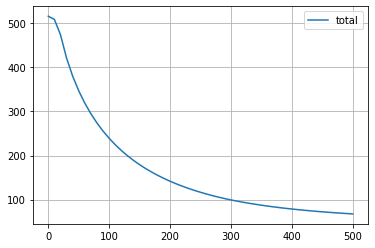

In [4]:
inputdata = read_inputjson_BCC_screw_single_calculation('../sample_input_NbMo_BCC_screw.json')
model = ss_model_M_C_screw(inputdata)
model.calculate()
plt.plot(model.T, model.tau_tot_T/1e6,label='total')
plt.grid()
plt.legend()

In [5]:
inputdata.data

{'material': 'Nb95Mo5',
 'model': 'BCC_screw_Maresca-Curtin-2019',
 'properties': {'a': 3.289,
  'E_k': 0.6342,
  'E_f_v': 2.989,
  'E_f_si': 5.361,
  'Delta_E_p': 0.0488,
  'Delta_V_p': 0.02},
 'conditions': {'temperature': {'max': 500, 'min': 0, 'inc': 10},
  'strain_r': 0.001},
 'adjustables': {'kink_width': 10,
  'Delta_V_p_scaler': 1,
  'Delta_E_p_scaler': 1},
 'savefile': 'Nb95Mo5_out'}

In [6]:
model.Delta_V_p

1.1249827559576266e-11

In [7]:
inputdata_TiNbZr = read_inputjson_BCC_screw_single_calculation('../sample_input_TiNbZr_BCC_screw.json')

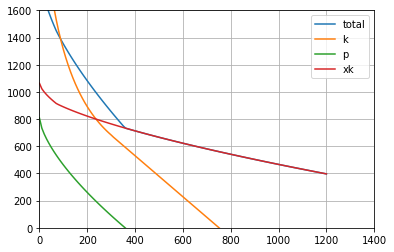

In [8]:
model_TiNbZr = ss_model_M_C_screw(inputdata_TiNbZr)
model_TiNbZr.calculate()
plt.plot(model_TiNbZr.T, model_TiNbZr.tau_tot_T/1e6*3.07,label='total')
plt.plot(model_TiNbZr.T, model_TiNbZr.tau_k_T/1e6*3.07,label='k')
plt.plot(model_TiNbZr.T, model_TiNbZr.tau_p_T/1e6*3.07,label='p')
plt.plot(model_TiNbZr.T, model_TiNbZr.tau_xk_T/1e6*3.07,label='xk')
plt.ylim(0,1600)
plt.xlim(0,1400)
plt.grid()
plt.legend()

In [9]:
inputdata_NbW = read_inputjson_BCC_screw_single_calculation('../sample_input_NbW_BCC_screw.json')

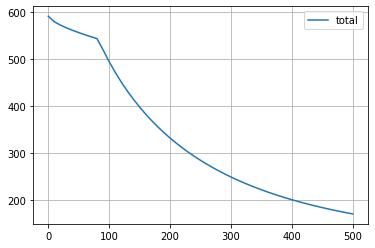

In [10]:
model_NbW = ss_model_M_C_screw(inputdata_NbW)
model_NbW.calculate()
plt.plot(model_NbW.T, model_NbW.tau_tot_T/1e6,label='total')
plt.grid()
plt.legend()

In [11]:
a_Fe = 2.866 * 10**(-10)
a_Fe = a_Fe*np.sqrt(2/3)  # Peierls spacing
b_Fe = a_Fe*np.sqrt(3)/2
Delta_V_p_Fe = 0.010977778 * model.eV2J 

In [12]:
np.pi*Delta_V_p_Fe/b_Fe/(b_Fe*a_Fe)/10**6

574.9389859733362

In [13]:
model.calc_data

,T,tau_y,tau_k,tau_xk,tau_p
0,0,516.31,895.05,46.48,469.83
1,10,509.21,505.79,45.18,464.03
2,20,474.32,429.89,44.42,460.62
3,30,421.40,377.61,43.79,457.76
4,40,380.40,337.18,43.22,455.21
5,50,346.95,304.26,42.69,452.87
6,60,318.85,276.64,42.20,450.68
7,70,294.75,253.01,41.74,448.60
8,80,273.80,232.50,41.30,446.63
9,90,255.38,214.50,40.88,444.73


In [14]:
# test write output
model.writedata('xxx')

-------------------------------Data Saved to xxx-------------------------------


In [35]:
# need to work on this

class ss_model_M_C_screw_single:
    # BCC screw dislocation model: Maresca-Curtin 2019: https://doi.org/10.1016/j.actamat.2019.10.007
    # similar to pseudo-ternary, but for single-composition calculations using c-weighted properties.

    def __init__(self,
                 adjustable_scalers,
                  conditions, # conditions = [[list of T],strain_r]
                  compositions,  # dict
                  elements_data   # dict 
                ):
        
        
        # adjustable scalers
        self.kink_width = adjustable_scalers['kink_width']  
        self.Delta_V_p_scaler = adjustable_scalers['Delta_V_p_scaler']  
        self.Delta_E_p_scaler = adjustable_scalers['Delta_E_p_scaler'] 
        
        # some constants
        self.boltzmann_J = 1.38064852*10**(-23) #J/K
        self.boltzmann_eV = 8.617333262145e-5 #eV
        self.J2eV = self.boltzmann_eV/self.boltzmann_J # covert J to eV 
        self.eV2J = 1/self.J2eV
        

        # properties
        self.elements_order = compositions.columns.to_list()
        self.compositions = copy.deepcopy(compositions)
        self.elements_data = copy.deepcopy(elements_data)
        cn_a = []
        cn_E_k = []
        cn_E_v = []
        cn_E_si = []
        cn_Delta_E_p = []
        cn_Delta_V_p = []
        comp_normalizer = sum([self.compositions[element_i].values for element_i in self.elements_order])
        for element_i in self.elements_order:
            cn_a.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['a'])
            cn_E_k.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['E_k'])
            cn_E_v.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['E_f_v'])
            cn_E_si.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['E_f_si'])
            cn_Delta_E_p.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['Delta_E_p']**2)
            cn_Delta_V_p.append(self.compositions[element_i].values/comp_normalizer*self.elements_data[element_i]['Delta_V_p'])

        self.a = sum(cn_a) * 10**(-10) 
        self.a_p = self.a*np.sqrt(2/3)  # Peierls spacing
        self.b = self.a*np.sqrt(3)/2    # burgers vector
        self.E_k = sum(cn_E_k) * self.eV2J 
        self.E_v = sum(cn_E_v) * self.eV2J 
        self.E_si = sum(cn_E_si) * self.eV2J 
        self.Delta_E_p = np.sqrt(sum(cn_Delta_E_p)) * self.Delta_E_p_scaler * self.eV2J 
        self.Delta_V_p = sum(cn_Delta_V_p) * self.Delta_V_p_scaler * self.eV2J /self.b
        
        # exp conditions
        self.T_range = conditions[0]
        self.strain_r =   conditions[1]  # strain rate
        self.strain_r_0 = 1e4                     # reference strain rate 10^4 /s
        
        self.w_k = self.kink_width * self.b                # kink width 
        self.xi_c = (1.083*self.E_k/self.Delta_E_p)**2*self.b     # characteristic length of dislocation segment 
        self.xi_si = self.xi_c * 15
        self.xi_v = self.xi_c * 7.5 
        
    def M_C_screw_model(self):
        
        # cross-kink
        # self-interstitial
        self.Delta_H =  self.boltzmann_J * self.T * np.log(self.strain_r_0/self.strain_r)               #activation enthalpy
        self.tau_xk_0_si = np.pi * self.E_si / (self.a_p * self.b * self.xi_si )
        self.tau_xk_si = self.tau_xk_0_si * (1-(self.Delta_H/self.E_si)**(2/3))
        # vacancy
        self.tau_xk_0_v = np.pi * self.E_v / (self.a_p * self.b * self.xi_v )
        self.tau_xk_v = self.tau_xk_0_v * (1-(self.Delta_H/self.E_v)**(2/3))
        
        # select the larger value from si or vacancy strengthening
        
        self.tau_xk_T = np.maximum(self.tau_xk_si,self.tau_xk_v)
        
        
                                
        
        
        # kink glide
        self.tau_b = 1.08 * self.E_k / (self.a_p * self.b * self.xi_c)
        self.tau_k_0 = 6.3 * self.Delta_E_p / (self.a_p * self.b**2 * np.sqrt(self.w_k/self.b)) + self.tau_b
        self.Delta_E_k_0 = 1.37 * np.sqrt(self.w_k/self.b) * self.Delta_E_p 
        self.tau_k_low_T = self.tau_b + \
                           (self.tau_k_0 - self.tau_b) / \
                           (np.exp(0.89*self.Delta_H/self.Delta_E_k_0 + \
                                   0.5*(self.Delta_H/self.Delta_E_k_0)**(1/4) + 0.6)-1)
        
        self.tau_k_high_T = self.tau_b - \
                            (self.tau_k_0 - self.tau_b) * self.w_k / (5.75 * self.xi_c) * \
                            (self.Delta_H/self.Delta_E_k_0 - np.log(5.75*self.xi_c/self.w_k+1))
        if (self.tau_k_low_T-self.tau_b)/(self.tau_k_0 - self.tau_b)>=(1/(5.75 * self.xi_c/self.w_k + 1)):
            self.tau_k_T = self.tau_k_low_T
        else:
            self.tau_k_T = self.tau_k_high_T
        
        # Peierls
        self.Delta_E_b_p =  (10*self.Delta_V_p*self.xi_c + 0.7 * self.E_k)**3/\
                            (20*self.Delta_V_p*self.xi_c + 0.7 * self.E_k)**2
        self.tau_p_0 = np.pi*self.Delta_V_p/(self.b*self.a_p ) + \
                       0.44 * self.E_k / (self.b*self.a_p * self.xi_c) * \
                      ( 1 - 5* self.Delta_V_p*self.xi_c/(20*self.Delta_V_p*self.xi_c+0.7*self.E_k))
        
        self.tau_p_T = self.tau_p_0 * (1-(self.Delta_H/self.Delta_E_b_p)**(2/3))
        
        # min of Peierls and kink glide
        self.min_tau_k_tau_p_T = np.minimum(self.tau_p_T,self.tau_k_T)
        
        # total strength
        self.tau_tot_T = np.maximum(self.min_tau_k_tau_p_T,0) + self.tau_xk_T
        self.V_act = self.a_p * self.b * self.w_k / 2.3 * ((self.tau_k_0-self.tau_b)/(self.tau_tot_T-self.tau_b)-1)

    def calculate(self):
        calc_data_all = []
        for composition_idx in range(len(self.compositions)):
            self.composition_idx = composition_idx
            for T in self.T_range:
                calc_data = self.compositions.iloc[self.composition_idx].to_dict()
                self.T = T
                self.M_C_screw_model()
                calc_data['T'] = self.T
                calc_data['tau_y'] = np.round(self.tau_tot_T/1e6,2)
                calc_data['tau_k'] = np.round(self.tau_k_T/1e6,2)
                calc_data['tau_xk'] = np.round(self.tau_xk_T/1e6,2)
                calc_data['tau_p'] = np.round(self.tau_p_T/1e6,2)
                calc_data['tau_xk_v'] = np.round(self.tau_xk_v/1e6,2)
                calc_data['tau_xk_si'] = np.round(self.tau_xk_si/1e6,2)
                calc_data['V_act'] = np.round(self.V_act/self.b**3,2) 
                calc_data_all.append(pd.DataFrame(calc_data))
                
                
        self.calc_data_all = (pd.concat(calc_data_all,ignore_index=True))
    def writedata(self,foutname):
        self.calc_data_all.to_csv(foutname,index=False,sep='\t',float_format='%.2f')
        print('-------------------------------Data Saved to {}-------------------------------'.format(foutname))



In [36]:

adjustable_scalers = inputdata.adjustable_scalers

In [37]:
adjustable_scalers['kink_width']=10
adjustable_scalers['Delta_V_p_scaler']=1
adjustable_scalers['Delta_E_p_scaler']=1

In [57]:

comp = { "Fe95Si5": 1 }
comp = { "Nb95Mo5": 100 }
#comp = { "TiNbZr": 100 }
#comp = { "Ti66Nb17Zr17": 100 }
compositions = pd.DataFrame(data=comp,index=[0])
compositions
temperature = np.arange(inputdata.conditions['temperature']['min'],
                           1200+2,
                           2)

conditions = [temperature,0.001]
sample_data = json.load(open('../sample_elements_data.json'))

elements_data = {}
for element_i in compositions.keys():
    elements_data[element_i] = sample_data['elements'][element_i]
elements_data = pd.DataFrame(data=elements_data)
elements_data
model_i = ss_model_M_C_screw_single(adjustable_scalers,conditions,compositions,elements_data)
model_i.calculate()


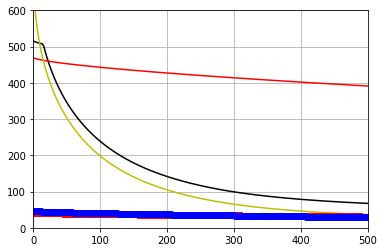

In [60]:

plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_y'],'k')
plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_p'],'r')
plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_xk'],'b')
plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_k'],'y')

plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_xk_si'],'s-r')
plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['tau_xk_v'],'o-b')
plt.ylim(0,600)
plt.xlim(0,500)
#plt.axhline(230)
plt.grid()

(0, 100)

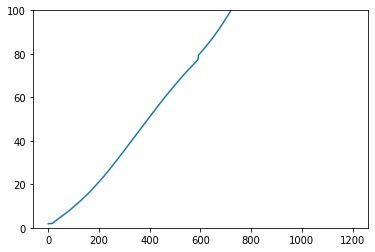

In [59]:
plt.plot(model_i.calc_data_all['T'],model_i.calc_data_all['V_act'])
plt.ylim(0,100)


In [51]:
mask = model_i.calc_data_all['T']==300

In [52]:
model_i.calc_data_all[mask]

,TiNbZr,T,tau_y,tau_k,tau_xk,tau_p,tau_xk_v,tau_xk_si,V_act
150,100,300,278.3,222.35,248.97,29.33,219.0,248.97,20.74


In [53]:
model_i.Delta_V_p*model_i.J2eV*model_i.b

array([0.0107])

In [54]:
model_i.tau_p_0*(1-(model_i.Delta_H/model_i.Delta_E_b_p)**(2/3)),model_i.calc_data_all['tau_p']

(array([-3.25905265e+08]), 0      263.06
 1      254.78
 2      249.91
 3      245.83
 4      242.19
         ...  
 596   -323.28
 597   -323.94
 598   -324.60
 599   -325.25
 600   -325.91
 Name: tau_p, Length: 601, dtype: float64)

In [48]:
model_i.eV2J

1.6021760769831632e-19

In [56]:
model_i.calc_data_all

,TiNbZr,T,tau_y,tau_k,tau_xk,tau_p,tau_xk_v,tau_xk_si,V_act
0,100,0,609.46,1274.33,346.41,263.06,346.41,327.77,3.87
1,100,2,596.67,950.86,341.89,254.78,341.89,324.98,4.08
2,100,4,589.16,895.86,339.24,249.91,339.24,323.34,4.21
3,100,6,582.85,858.43,337.02,245.83,337.02,321.97,4.33
4,100,8,577.23,828.98,335.04,242.19,335.04,320.74,4.43
...,...,...,...,...,...,...,...,...,...
596,100,1192,130.10,-216.82,130.10,-323.28,26.78,130.10,471.12
597,100,1194,129.87,-217.81,129.87,-323.94,26.42,129.87,484.33
598,100,1196,129.65,-218.79,129.65,-324.60,26.07,129.65,498.29
599,100,1198,129.43,-219.77,129.43,-325.25,25.71,129.43,513.06
